In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt

import spacy
import re
import string
import nltk
from nltk.corpus import stopwords
import wordcloud

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from tensorflow.keras import layers
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

from keras.initializers import Constant
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

import warnings

In [4]:
from IPython.display import HTML
def pretty_print_df(value_counts_):
    "Quick function to display value counts more nicely"
    display(HTML(pd.DataFrame(value_counts_).to_html()))

In [5]:
plt.style.use(style="seaborn")
%matplotlib inline

# Data Preparation

In [6]:
reviews = pd.read_csv('Reviews.csv', index_col=0)

In [7]:
reviews.columns

Index(['Name', 'Address', 'Phone_Number', 'Latitude', 'Longitude', 'Rating',
       'No_of_reviews', 'Place_ID', 'Review_text', 'Review_rate'],
      dtype='object')

In [8]:
reviews = reviews[['Review_text','Review_rate']]

In [9]:
reviews.head()

,Review_text,Review_rate
0,It's free..! Loads of British pictures through...,5.0
1,Wonderful place to spend a few hours. So much ...,5.0
2,Visited the amazing Life Between Islands exhib...,5.0
3,"After up 8 floors in lift... Sorry, closed for...",1.0
4,Amazing to walk into the Hew Locke structure c...,5.0


In [10]:
Reviews = reviews.copy() # Maintaining the original dataset

In [11]:
Reviews.head()

,Review_text,Review_rate
0,It's free..! Loads of British pictures through...,5.0
1,Wonderful place to spend a few hours. So much ...,5.0
2,Visited the amazing Life Between Islands exhib...,5.0
3,"After up 8 floors in lift... Sorry, closed for...",1.0
4,Amazing to walk into the Hew Locke structure c...,5.0


In [12]:
reviews.isnull().sum() # Check where the nulls occur

Review_text    0
Review_rate    0
dtype: int64

In [13]:
dup = reviews.duplicated()
c = 0
for i in range (0,len(dup)):
    if dup[i] == True:
        c=c+1
print('Number of duplicates:',c)

Number of duplicates: 47


In [14]:
reviews.describe()

,Review_rate
count,13383.000000
mean,4.264888
std,1.281368
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


# Text Cleaning

In [15]:
# URL & HTML Removal
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

In [16]:
# Punctuation Removal
def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

In [17]:
#Stopwords Removal
stop = set(stopwords.words("english"))
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

In [18]:
reviews["Review_text"] = reviews["Review_text"].map(lambda x: remove_URL(x))
reviews["Review_text"] = reviews["Review_text"].map(lambda x: remove_html(x))
reviews["Review_text"] = reviews["Review_text"].map(lambda x: remove_punct(x))
reviews["Review_text"] = reviews["Review_text"].map(remove_stopwords)
reviews['Review_text'] = reviews['Review_text'].apply(lambda x: nltk.WordNetLemmatizer().lemmatize(x)) # Lemmatizing JIC

In [19]:
reviews.head()

,Review_text,Review_rate
0,free loads british pictures centuries lots loo...,5.0
1,wonderful place spend hours much see free much...,5.0
2,visited amazing life islands exhibition tate b...,5.0
3,8 floors lift sorry closed private function da...,1.0
4,amazing walk hew locke structure called proces...,5.0


In [20]:
Reviews.head()

,Review_text,Review_rate
0,It's free..! Loads of British pictures through...,5.0
1,Wonderful place to spend a few hours. So much ...,5.0
2,Visited the amazing Life Between Islands exhib...,5.0
3,"After up 8 floors in lift... Sorry, closed for...",1.0
4,Amazing to walk into the Hew Locke structure c...,5.0


# Feature Engineering

In [21]:
def sentiments(df):
    if df['Review_rate'] > 3.0:
        return 'Positive'
    elif df['Review_rate'] < 3.0:
        return 'Negative'
    else: return 'Neutral'

In [22]:
reviews["length"] = reviews['Review_text'].map(lambda x: len(x))
reviews["word_count"] = reviews['Review_text'].str.split().map(lambda x: len(x))
reviews['sentiment'] = reviews.apply(sentiments, axis=1)

In [23]:
reviews.describe().apply(lambda s: s.apply('{0:.1f}'.format))

,Review_rate,length,word_count
count,13383.0,13383.0,13383.0
mean,4.3,155.8,22.9
std,1.3,152.6,22.3
min,1.0,0.0,0.0
25%,4.0,57.0,9.0
50%,5.0,116.0,17.0
75%,5.0,205.0,30.0
max,5.0,3088.0,443.0


In [24]:
stars = reviews['Review_rate'].value_counts()
pretty_print_df(stars)

,Review_rate
5.0,8977
4.0,1951
1.0,1274
3.0,752
2.0,429


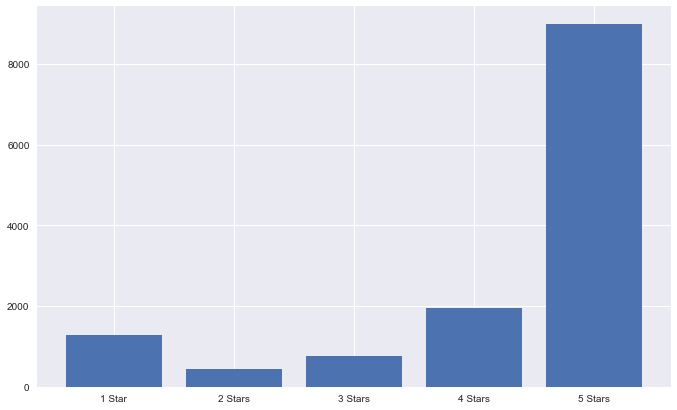

In [25]:
plt.figure(1, figsize=(25, 7))
plt.subplot(1, 2, 1)
_ = plt.bar(["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"], [stars[1],stars[2],stars[3],stars[4],stars[5]])
plt.savefig('Star Distribution.pdf')
plt.show()

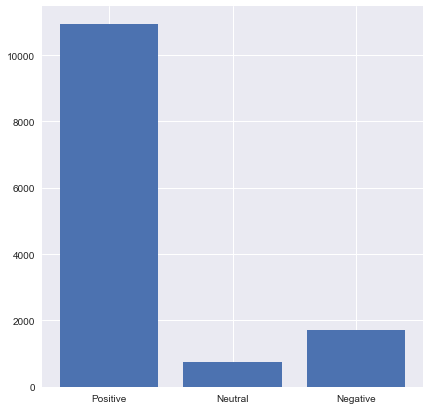

In [26]:
# All
x = reviews.loc[reviews['sentiment'] == 'Positive']
y = reviews.loc[reviews['sentiment'] == 'Negative']
z = reviews.loc[reviews['sentiment'] == 'Neutral']

plt.figure(1, figsize=(15, 7))
plt.subplot(1, 2, 1)
_ = plt.bar(["Positive", "Neutral" ,"Negative"], [x.shape[0],z.shape[0],y.shape[0]])
plt.savefig('Sentiment Distribution.pdf')
plt.show()

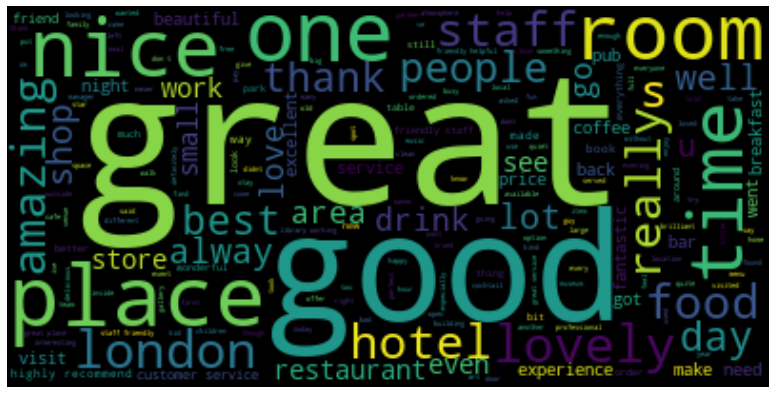

In [27]:
plt.figure(1, figsize=(20, 7))
common_words=''
for i in reviews.Review_text:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('Wordcloud.pdf')
plt.show()

# NLP Preparation

In [28]:
# 2 for Positive (4 & 5 Stars), 1 for Neutral (3 Stars) ,0 for Negative (1 & 2 Stars)
se = preprocessing.LabelEncoder()

s = reviews.sentiment
enc_s = se.fit_transform(s)

In [29]:
ML = df({
    'Text': reviews.Review_text,
    'Rate': reviews.Review_rate,
    'Sentiment': enc_s,
})
ML

,Text,Rate,Sentiment
0,free loads british pictures centuries lots loo...,5.0,2
1,wonderful place spend hours much see free much...,5.0,2
2,visited amazing life islands exhibition tate b...,5.0,2
3,8 floors lift sorry closed private function da...,1.0,0
4,amazing walk hew locke structure called proces...,5.0,2
...,...,...,...
13378,nice bar friendly staff prices steep,4.0,2
13379,great service great cocktails,5.0,2
13380,great atmosphere lovely staff,5.0,2
13381,amazing bar staff friendly good drinks,5.0,2


In [30]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
tokenizer2 = TreebankWordTokenizer()

stemmer = PorterStemmer()


def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]

    return " ".join(text)

In [31]:
ML["Text"] = ML["Text"].map(stemming)

In [32]:
ML.describe()

,Rate,Sentiment
count,13383.000000,13383.000000
mean,4.264888,1.689307
std,1.281368,0.684616
min,1.000000,0.000000
25%,4.000000,2.000000
50%,5.000000,2.000000
75%,5.000000,2.000000
max,5.000000,2.000000


Count Unique

In [33]:
count = Counter()
for i in ML.Text.values:
    for word in i.split():
        count[word] += 1

In [34]:
wordcount = len(count)
wordcount

15926

Data Splitting

In [35]:
train_size = int(ML.shape[0] * 0.8)

train = ML.Text[:train_size]
train_labels = ML.Rate[:train_size]

test = ML.Text[train_size:]
test_labels = ML.Rate[train_size:]

Tokenizing

In [36]:
tokenizer = Tokenizer(num_words=wordcount)
tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index

In [37]:
print("Number of unique words:", len(word_index))

Number of unique words: 13954


Seq & Pad

In [38]:
train_seq = tokenizer.texts_to_sequences(train)

max_len = 100
train_padded = pad_sequences(train_seq, maxlen=max_len, truncating="post", padding="post")

In [39]:
test_seq = tokenizer.texts_to_sequences(test)
test_padded = pad_sequences(test_seq, maxlen=max_len, padding="post", truncating="post")

Inv & Decode

In [40]:
# Decoding function
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

In [41]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [42]:
# Checking a random sample
print(ML.Text[172])
print(train_seq[172])

visit pub recent realli pleasant time serv staci warm friendli made us laugh got us tabl made realli comfort us get drink despit bust great way start even ahead show plan
[18, 70, 392, 14, 279, 10, 101, 7122, 258, 9, 72, 34, 1123, 89, 34, 104, 72, 14, 135, 34, 21, 43, 568, 3197, 1, 103, 237, 26, 1828, 207, 589]


In [43]:
decode(train_seq[172])

'visit pub recent realli pleasant time serv staci warm friendli made us laugh got us tabl made realli comfort us get drink despit bust great way start even ahead show plan'

MC LR Rate

In [44]:
def evaluate_classifier(grid, X_train, y_train, X_test, y_test):
    # model evaluation for training set
    y_train_predict = grid.predict(X_train)
    print("Training SET")
    print("--------------------------------------")
    print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_train, y_train_predict), 
                                                                                        precision_score(y_train, y_train_predict, average='weighted'), 
                                                                                        recall_score(y_train, y_train_predict, average='weighted'), 
                                                                                        f1_score(y_train, y_train_predict,average='weighted')))
    print("Confusion Matrix:\n {}".format(confusion_matrix(y_train, y_train_predict)))

    # model evaluation for testing set
    y_test_predict = grid.predict(X_test)

    print("\nTesting SET")
    print("--------------------------------------")
    print('Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}'.format(accuracy_score(y_test, y_test_predict), 
                                                                                        precision_score(y_test, y_test_predict, average='weighted'), 
                                                                                        recall_score(y_test, y_test_predict, average='weighted'), 
                                                                                        f1_score(y_test, y_test_predict, average='weighted')))
    print("Confusion Matrix:\n {}".format(confusion_matrix(y_test, y_test_predict)))
    return y_train_predict, y_test_predict

In [45]:
def tfidf(data, ngrams=(1, 2)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

In [46]:
train_tfidf, tfidf_vectorizer = tfidf(train)
test_tfidf = tfidf_vectorizer.transform(test)

In [47]:
model = LogisticRegression(class_weight="balanced", max_iter=1000)
model.fit(train_tfidf, train_labels)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [48]:
y_pred = model.predict(test_tfidf)
f1score = f1_score(test_labels, y_pred, average='weighted')
accuracy = accuracy_score(test_labels, y_pred)

print(f"Model F1-Score: {f1score * 100} %")
print(f"Model Accuracy: {accuracy * 100} %")

Model F1-Score: 68.81686378947428 %
Model Accuracy: 68.43481509152036 %


In [49]:
y_train_predict, y_test_predict = evaluate_classifier(model, train_tfidf, train_labels, test_tfidf, test_labels)

Training SET
--------------------------------------
Accuracy: 0.921, Precision: 0.935, Recall: 0.921, F1 Score: 0.924
Confusion Matrix:
 [[1019    1    0    1    8]
 [   0  349    1    0    0]
 [   0    0  588    2    5]
 [   5    0    8 1484   60]
 [  99    4   71  583 6418]]

Testing SET
--------------------------------------
Accuracy: 0.684, Precision: 0.701, Recall: 0.684, F1 Score: 0.688
Confusion Matrix:
 [[ 198   15   10   10   12]
 [  29    6   15   19   10]
 [  22   11   23   68   33]
 [  26    4   21  172  171]
 [  49    4   41  275 1433]]


In [50]:
for i in range (train_size, train_size+10):
    print('Original Text:\n',Reviews.Review_text[i])
    print('Real Score:',test_labels[i])
    print('Predicted Score:', y_pred[i-train_size])
    print('----------------------------------------')

Original Text:
 Was very delicious. Specially meats and cold starters are perfect. Service was perfect too friendly and smiley staff. Highly recommended  to anyone who loves Mediterranean cuisine.
Real Score: 5.0
Predicted Score: 5.0
----------------------------------------
Original Text:
 Lovely food! We had the cold starters and family platter which we all enjoyed! Waiting staff were friendly, however -1 star for the man with glasses and light blue shirt who I suppose is the owner/manager, as he came across a bit cold and we felt like he was ignoring us, perhaps deliberately? Also they weren't serving any baklava which was a tad disappointing.
Real Score: 4.0
Predicted Score: 3.0
----------------------------------------
Original Text:
 For a spontaneous lunch idea it was great. Wasn't that busy as it was Sunday midday and they had probably just opened. The workers were lovely and friendly. The mint lemonade was great for the hot day! I had the tribute burger. As burgers go it was goo

MC liblinear LR Rate

In [51]:
train_size = int(ML.shape[0] * 0.8)

train = ML.Text[:train_size]
train_labels = ML.Rate[:train_size]

test = ML.Text[train_size:]
test_labels = ML.Rate[train_size:]

In [52]:
train_tfidf, tfidf_vectorizer = tfidf(train)
test_tfidf = tfidf_vectorizer.transform(test)

In [53]:
model = LogisticRegression(class_weight="balanced", solver='liblinear', penalty='l2')
model.fit(train_tfidf, train_labels)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [54]:
y_pred = model.predict(test_tfidf)
f1score = f1_score(test_labels, y_pred, average='weighted')
accuracy = accuracy_score(test_labels, y_pred)

print(f"Model F1-Score: {f1score * 100} %")
print(f"Model Accuracy: {accuracy * 100} %")

Model F1-Score: 69.31964986247239 %
Model Accuracy: 73.29099738513261 %


In [55]:
y_train_predict, y_test_predict = evaluate_classifier(model, train_tfidf, train_labels, test_tfidf, test_labels)

Training SET
--------------------------------------
Accuracy: 0.929, Precision: 0.928, Recall: 0.929, F1 Score: 0.926
Confusion Matrix:
 [[1000    2    2    1   24]
 [   5  343    1    1    0]
 [   3    1  556    5   30]
 [   7    0    7 1039  504]
 [  30    0   18  115 7012]]

Testing SET
--------------------------------------
Accuracy: 0.733, Precision: 0.674, Recall: 0.733, F1 Score: 0.693
Confusion Matrix:
 [[ 188    9    8    6   34]
 [  29    5    5   10   30]
 [  19    6   15   40   77]
 [  17    3   14   80  280]
 [  28    1   16   83 1674]]


In [57]:
for i in range (train_size+10, train_size+20):
    print('Original Text:\n',Reviews.Review_text[i])
    print('Real Score:',test_labels[i])
    print('Predicted Score:', y_pred[i-train_size])
    print('----------------------------------------')

Original Text:
 Didn't get the ramen burger as I'm a lover of bao was went for the two veggie bao options! The tofu was nice and crispy but I felt it needed some more sauce or flavour. The quinoa, pumpkin bao on the other hand was perfect! Really fresh and flavourful!
Real Score: 4.0
Predicted Score: 5.0
----------------------------------------
Original Text:
 They’re ok. The melted cheese was the tastiest part of the Classic Burger. The veggie option was pretty good.
Real Score: 3.0
Predicted Score: 3.0
----------------------------------------
Original Text:
 Our fave place in Greenwich! Amazing food, music and people. Always so welcoming. My partner and I go here all the time. We attempt to try new places and always keep ending up back here. 110% recommend.
Real Score: 5.0
Predicted Score: 5.0
----------------------------------------
Original Text:
 Lovely Place.
Food Cooked To Perfection.
Friendly Staff.
Toilets Available.
Bus Stop Nearby.
I Had A Chicken Burger Which Was A Proper C

MC LR Sentiment

In [59]:
train_size = int(ML.shape[0] * 0.8)

train = ML.Text[:train_size]
train_labels = ML.Sentiment[:train_size]

test = ML.Text[train_size:]
test_labels = ML.Sentiment[train_size:]

In [60]:
train_tfidf, tfidf_vectorizer = tfidf(train)
test_tfidf = tfidf_vectorizer.transform(test)

In [61]:
model = LogisticRegression(class_weight="balanced", max_iter=1000)
model.fit(train_tfidf, train_labels)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [62]:
y_pred = model.predict(test_tfidf)
f1score = f1_score(test_labels, y_pred, average='weighted')
accuracy = accuracy_score(test_labels, y_pred)

print(f"Model F1-Score: {f1score * 100} %")
print(f"Model Accuracy: {accuracy * 100} %")

Model F1-Score: 87.14113823035318 %
Model Accuracy: 87.22450504295853 %


In [63]:
y_train_predict, y_test_predict = evaluate_classifier(model, train_tfidf, train_labels, test_tfidf, test_labels)

Training SET
--------------------------------------
Accuracy: 0.977, Precision: 0.979, Recall: 0.977, F1 Score: 0.977
Confusion Matrix:
 [[1369    2    8]
 [   0  590    5]
 [ 111  123 8498]]

Testing SET
--------------------------------------
Accuracy: 0.872, Precision: 0.872, Recall: 0.872, F1 Score: 0.871
Confusion Matrix:
 [[ 255   21   48]
 [  40   38   79]
 [  77   77 2042]]


In [73]:
for i in range (train_size, train_size+10):
    print('Original Text:\n',Reviews.Review_text[i])
    print('Real Sentiment:',se.inverse_transform([test_labels[i]]))
    print('Predicted Score:', se.inverse_transform([y_pred[i-train_size]]))
    print('----------------------------------------')

Original Text:
 Was very delicious. Specially meats and cold starters are perfect. Service was perfect too friendly and smiley staff. Highly recommended  to anyone who loves Mediterranean cuisine.
Real Sentiment: ['Positive']
Predicted Score: ['Positive']
----------------------------------------
Original Text:
 Lovely food! We had the cold starters and family platter which we all enjoyed! Waiting staff were friendly, however -1 star for the man with glasses and light blue shirt who I suppose is the owner/manager, as he came across a bit cold and we felt like he was ignoring us, perhaps deliberately? Also they weren't serving any baklava which was a tad disappointing.
Real Sentiment: ['Positive']
Predicted Score: ['Neutral']
----------------------------------------
Original Text:
 For a spontaneous lunch idea it was great. Wasn't that busy as it was Sunday midday and they had probably just opened. The workers were lovely and friendly. The mint lemonade was great for the hot day! I had t

MC Liblinear LR Sentiment

In [ ]:
train_size = int(ML.shape[0] * 0.8)

train = ML.Text[:train_size]
train_labels = ML.Sentiment[:train_size]

test = ML.Text[train_size:]
test_labels = ML.Sentiment[train_size:]

In [ ]:
train_tfidf, tfidf_vectorizer = tfidf(train)
test_tfidf = tfidf_vectorizer.transform(test)

In [74]:
model = LogisticRegression(class_weight="balanced", solver='liblinear', penalty='l2')
model.fit(train_tfidf, train_labels)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [75]:
y_pred = model.predict(test_tfidf)
f1score = f1_score(test_labels, y_pred, average='weighted')
accuracy = accuracy_score(test_labels, y_pred)

print(f"Model F1-Score: {f1score * 100} %")
print(f"Model Accuracy: {accuracy * 100} %")

Model F1-Score: 86.4393224597665 %
Model Accuracy: 88.6066492342174 %


In [76]:
y_train_predict, y_test_predict = evaluate_classifier(model, train_tfidf, train_labels, test_tfidf, test_labels)

Training SET
--------------------------------------
Accuracy: 0.980, Precision: 0.980, Recall: 0.980, F1 Score: 0.979
Confusion Matrix:
 [[1273    3  103]
 [   6  518   71]
 [  25   10 8697]]

Testing SET
--------------------------------------
Accuracy: 0.886, Precision: 0.855, Recall: 0.886, F1 Score: 0.864
Confusion Matrix:
 [[ 218    7   99]
 [  26    9  122]
 [  36   15 2145]]


In [77]:
for i in range (train_size, train_size+10):
    print('Original Text:\n',Reviews.Review_text[i])
    print('Real Sentiment:',se.inverse_transform([test_labels[i]]))
    print('Predicted Score:', se.inverse_transform([y_pred[i-train_size]]))
    print('----------------------------------------')

Original Text:
 Was very delicious. Specially meats and cold starters are perfect. Service was perfect too friendly and smiley staff. Highly recommended  to anyone who loves Mediterranean cuisine.
Real Sentiment: ['Positive']
Predicted Score: ['Positive']
----------------------------------------
Original Text:
 Lovely food! We had the cold starters and family platter which we all enjoyed! Waiting staff were friendly, however -1 star for the man with glasses and light blue shirt who I suppose is the owner/manager, as he came across a bit cold and we felt like he was ignoring us, perhaps deliberately? Also they weren't serving any baklava which was a tad disappointing.
Real Sentiment: ['Positive']
Predicted Score: ['Positive']
----------------------------------------
Original Text:
 For a spontaneous lunch idea it was great. Wasn't that busy as it was Sunday midday and they had probably just opened. The workers were lovely and friendly. The mint lemonade was great for the hot day! I had 